In [1]:
!pip install numpy pandas matplotlib scikit-learn torch livelossplot torchsummary

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from livelossplot import PlotLosses
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load data

In [61]:
data = np.load('../../Data/Ferguson_fire_train.npy')
test_data = np.load('../../Data/Ferguson_fire_test.npy')
print(data.shape)

(12500, 256, 256)


In [62]:
train_data = np.array(data)
validation_data = np.array(test_data)

### Split 2500 data from the training data into validation data 
Since every 100 samples are grouped and may have a time step, split 100 validation data from every 500 data

In [63]:
# split data into train and validation
# train_data = []
# validation_data = []

# for i in range(0, len(data), 500):
#     train_data.extend(data[i:i+400])
#     validation_data.extend(data[i+400:i+500])
    
# train_data = np.array(train_data)
# validation_data = np.array(validation_data)

# train_data = train_data[4000:,:,:]
# validation_data = validation_data[1000:,:,:]

print('Train data shape:', train_data.shape)
print('Validation data shape:', validation_data.shape)
# print('Test data shape:', test_data.shape)


Train data shape: (12500, 256, 256)
Validation data shape: (5000, 256, 256)


In [64]:
def data_reformat(data):
    time_step = 100
    height, width = data.shape[1], data.shape[2]

    num_sequences = data.shape[0] // time_step
    reshaped_data = data[:num_sequences * time_step].reshape((num_sequences, time_step, height, width,))

    # only take 0,10,20,30,40,50,60,70,80,90 time steps from each sequence
    reshaped_data = reshaped_data[:, ::2, :, :]

    return reshaped_data

train_data = data_reformat(train_data)
validation_data = data_reformat(validation_data)

print('Train data shape:', train_data.shape)
print('Validation data shape:', validation_data.shape)

Train data shape: (125, 50, 256, 256)
Validation data shape: (50, 50, 256, 256)


In [65]:
# fig, ax = plt.subplots(1, 20, figsize=(15, 5))
# for i in range(20):
#     ax[i].imshow(train_data[40, i,:,:])
#     ax[i].axis('off')

Train t data shape: (125, 49, 256, 256)
Train t+1 data shape: (125, 49, 256, 256)


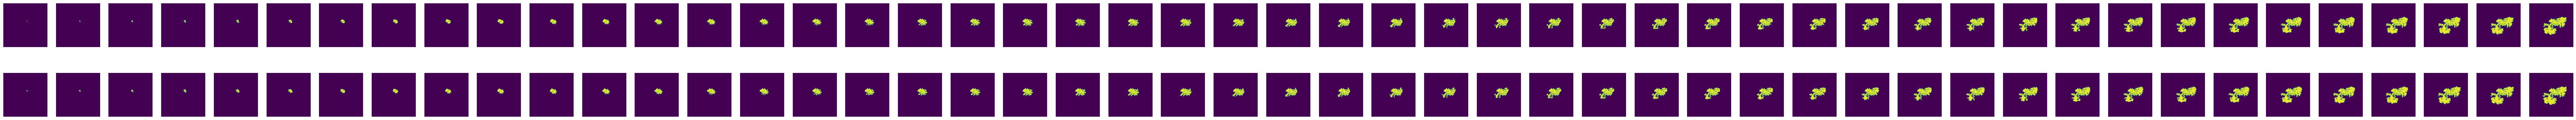

In [69]:
# create t and t+1 data group
def create_data_group(data):
    t_data = data[:, :-1]
    t1_data = data[:, 1:]
    
    return t_data, t1_data

train_t_data, train_t1_data = create_data_group(train_data)
validation_t_data, validation_t1_data = create_data_group(validation_data)

print('Train t data shape:', train_t_data.shape)
print('Train t+1 data shape:', train_t1_data.shape)

fig, ax = plt.subplots(2, 49, figsize=(100, 5))
for i in range(49):
    ax[0, i].imshow(train_t_data[40, i,:,:])
    ax[0, i].axis('off')
    ax[1, i].imshow(train_t1_data[40, i,:,:])
    ax[1, i].axis('off')

## Build network and train autoencoder

### Create data loader

In [70]:
class WildfireDataset3D(Dataset):
    def __init__(self, t_images, t1_images):
        self.t_images = t_images
        self.t1_images = t1_images

    def __len__(self):
        return self.t_images.shape[0]

    def __getitem__(self, idx):
        img_t = self.t_images[idx]
        img_t1 = self.t1_images[idx]
        img_t = torch.tensor(img_t, dtype=torch.float32).unsqueeze(0).permute(0, 1, 3, 2,)
        img_t1 = torch.tensor(img_t1, dtype=torch.float32).unsqueeze(0).permute(0, 1, 3, 2)
        # img_t = torch.tensor(img_t, dtype=torch.float32)
        # img_t1 = torch.tensor(img_t1, dtype=torch.float32)
        return img_t, img_t1


In [71]:

train_dataset = WildfireDataset3D(train_t_data, train_t1_data)
validation_dataset = WildfireDataset3D(validation_t_data, validation_t1_data)

print('Train dataset length:', len(train_dataset))
print('Validation dataset length:', len(validation_dataset))

train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=25, shuffle=False)

Train dataset length: 125
Validation dataset length: 50


In [72]:
for images_t, images_t1 in train_loader:
    print('Train t data shape:', images_t.shape)
    print('Train t+1 data shape:', images_t1.shape)
    break

print(f'length of dataloader: {len(train_loader)}')


Train t data shape: torch.Size([25, 1, 49, 256, 256])
Train t+1 data shape: torch.Size([25, 1, 49, 256, 256])
length of dataloader: 5


# test

### Build the model

In [85]:

class Encoder(nn.Module):
    def __init__(self, z_dim=16):
        super(Encoder, self).__init__()
        self.enc_conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1)  # (B, 32, 5, 128, 128)
        self.enc_conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1)  # (B, 64, 3, 64, 64)
        self.enc_conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1)  # (B, 128, 2, 32, 32)

        self.fc_mu = nn.Linear(128*7*32*32, z_dim)
        self.fc_logvar = nn.Linear(128*7*32*32, z_dim)

    def forward(self, x):
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        h = F.relu(self.enc_conv3(h))
        print("After enc_conv3:", h.shape)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, z_dim=16):
        super(Decoder, self).__init__()
        self.fc_decode = nn.Linear(z_dim, 128*7*32*32)
        self.dec_conv1 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0,1,1))
        self.dec_conv2 = nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(0,1,1))
        self.dec_conv3 = nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=(0,1,1))

    def forward(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 7, 32, 32)
        h = F.relu(self.dec_conv1(h))
        h = F.relu(self.dec_conv2(h))
        h = torch.sigmoid(self.dec_conv3(h))
        return h


In [86]:
class Conv3DVAE(nn.Module):
    def __init__(self, z_dim=16):
        super(Conv3DVAE, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [87]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


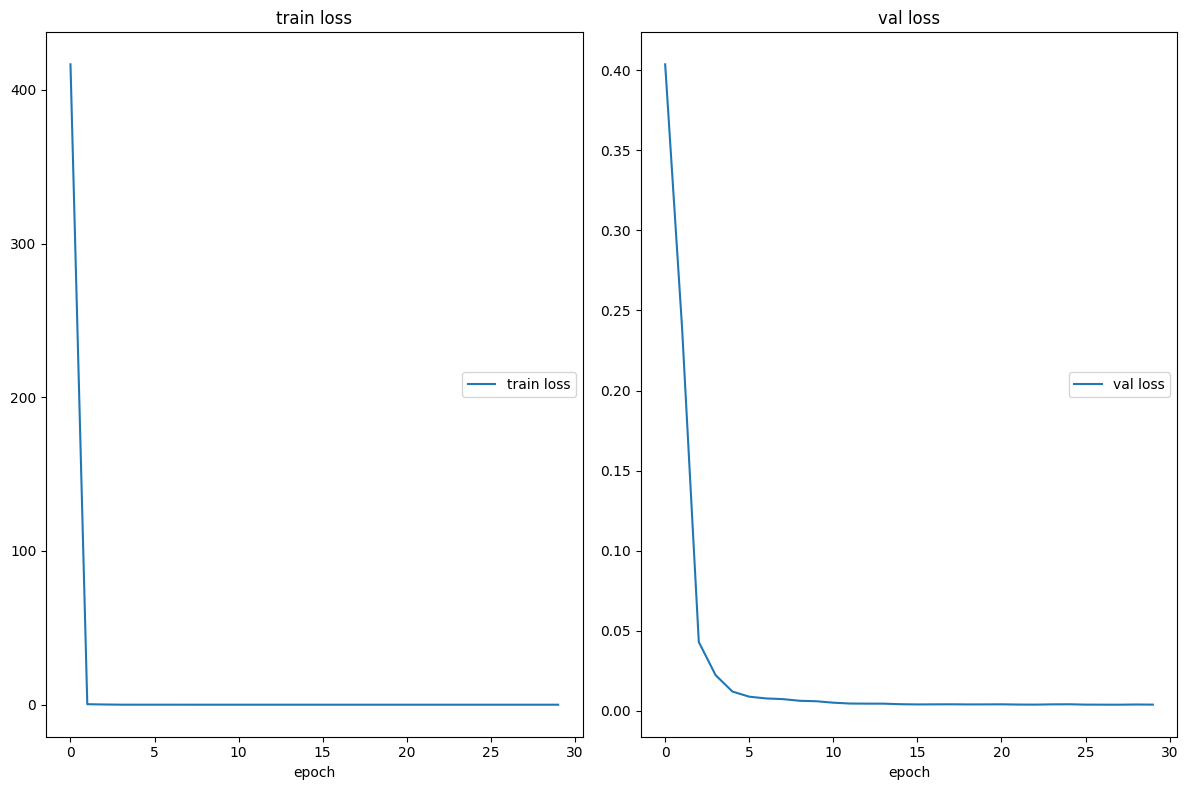

train loss
	train loss       	 (min:    0.004, max:  416.597, cur:    0.004)
val loss
	val loss         	 (min:    0.004, max:    0.404, cur:    0.004)


In [88]:
model = Conv3DVAE(z_dim=16).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
liveloss = PlotLosses() 
num_epochs = 30
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Train loss: {avg_train_loss}')

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.cuda(), target.cuda()
            recon, mu, logvar = model(data)
            val_loss += loss_function(recon, target, mu, logvar).item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch {epoch}, Validation loss: {avg_val_loss}')

    scheduler.step(avg_val_loss)
    
    liveloss.update({
            'train loss': avg_train_loss,
            'val loss': avg_val_loss
        })
    liveloss.draw()
    

In [90]:
summary(model, (1, 49, 256, 256))

After enc_conv3: torch.Size([2, 128, 7, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 25, 128, 128]             896
            Conv3d-2       [-1, 64, 13, 64, 64]          55,360
            Conv3d-3       [-1, 128, 7, 32, 32]         221,312
            Linear-4                   [-1, 16]      14,680,080
            Linear-5                   [-1, 16]      14,680,080
           Encoder-6       [[-1, 16], [-1, 16]]               0
            Linear-7               [-1, 917504]      15,597,568
   ConvTranspose3d-8       [-1, 64, 13, 64, 64]         221,248
   ConvTranspose3d-9     [-1, 32, 25, 128, 128]          55,328
  ConvTranspose3d-10      [-1, 1, 49, 256, 256]             865
          Decoder-11      [-1, 1, 49, 256, 256]               0
Total params: 45,512,737
Trainable params: 45,512,737
Non-trainable params: 0
----------------------------------------

In [40]:
# def filter_data(data, low_threshold, high_threshold):
#     data[data < low_threshold] = 0
#     data[data >= high_threshold] = 1
#     return data  

In [91]:
model.eval()
with torch.no_grad():
    z = torch.randn(1, 16).to(device)
    sample = model.decoder(z)
    sample = sample.cpu().numpy()

print(sample.shape)

(1, 1, 49, 256, 256)


In [ ]:
# sample = sample[:, :,::10, :, :]

fig, ax = plt.subplots(1, 16, figsize=(15, 5))
for i in range(16):
    ax[i].imshow(sample[0,0,i,:,:])
    ax[i].axis('off')

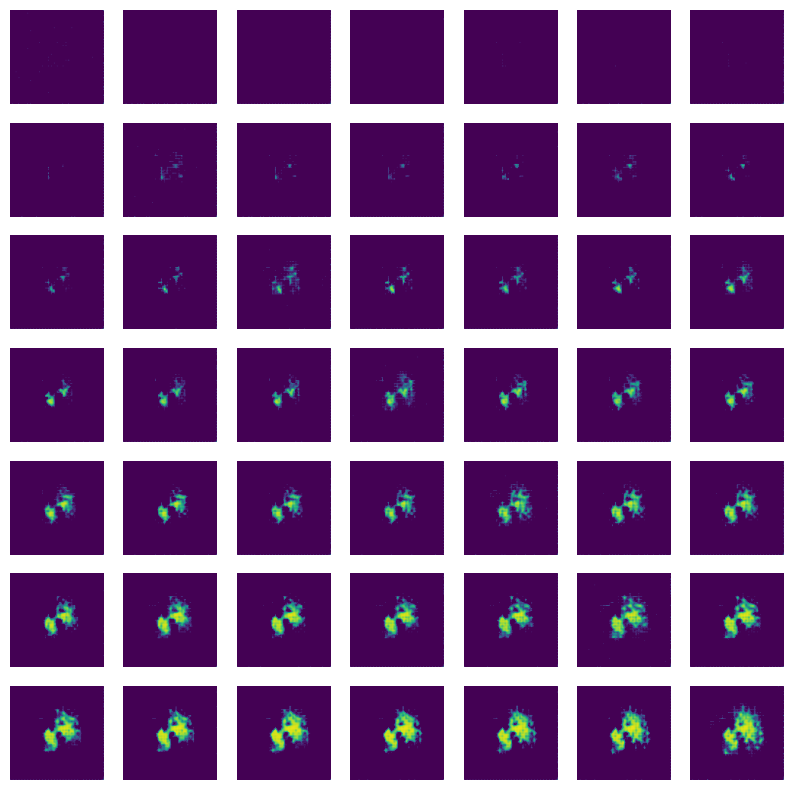

In [93]:
fig, ax = plt.subplots(7, 7, figsize=(10, 10))

# Iterate over the 49 images and plot each in the grid
for i in range(49):
    row = i // 7  # Determine the row index
    col = i % 7 # Determine the column index
    ax[row, col].imshow(sample[0, 0, i, :, :]) 
    ax[row, col].axis('off')

In [39]:
# # save the model
# torch.save(model, 'vae.pth')
# # save model state
# torch.save(model.state_dict(), 'vae_state_dict.pth')

In [28]:
model_data = np.load('../../Data/Ferguson_fire_background.npy')
satellite_data = np.loea('../../Data/Ferguson_fire_obs.npy')

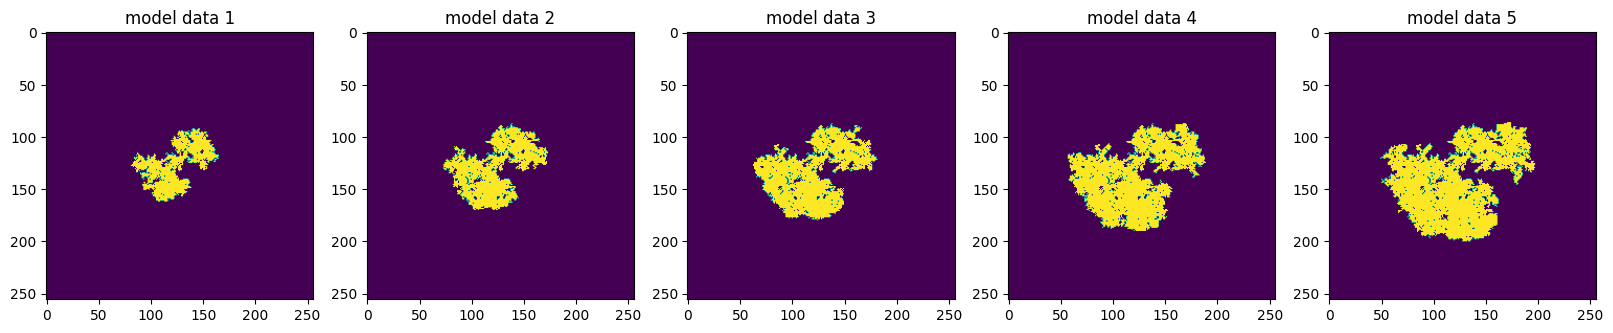

In [31]:
fig, ax = plt.subplots(1,5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(satellite_data[i, :, :])
    ax[i].set_title(f'satellite data {i+1}')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

generated_images = sample[0, 0, :, :, :]

min_mse = float('inf')
min_mse_generated_image = None
min_mse_satellite_image = None

for i, gen_img in enumerate(generated_images):
    for j, satellite_img in enumerate(satellite_data):
        mse = mean_squared_error(gen_img.flatten(), satellite_img.flatten())
        if mse < min_mse:
            min_mse = mse
            min_mse_generated_image = gen_img
            min_mse_satellite_image = satellite_img

print(f"Min MSE: {min_mse}")


import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(min_mse_generated_image)
axs[0].set_title('Generated Image with Min MSE')
axs[0].axis('off')

axs[1].imshow(min_mse_satellite_image)
axs[1].set_title('satellite Image with Min MSE')
axs[1].axis('off')

plt.show()


In [1]:
# find the minimum mse between satellite data and sample data and get the dataframes

satellite_data_index = []
sample_data_index = []
mse = []
for i in satellite_data:
    for j in sample:
        mse.append(mean_squared_error(i.flatten(), j.flatten()))
        satellite_data_index.append(np.where(satellite_data == i))
        sample_data_index.append(np.where(sample == j))

result = pd.DataFrame({'satellite_data_index': satellite_data_index, 'sample_data_index': sample_data_index, 'mse': mse})
result = result.sort_values('mse')


NameError: name 'model_data' is not defined

In [ ]:
# showing the first image of satellite_data and 45th image of sample data
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(satellite_data[0, :, :])
ax[0].set_title('satellite data')
ax[1].imshow(sample[45, :, :])
ax[1].set_title('sample data')


In [ ]:
# show 45 55 65 75th images of sample data
fig, ax = plt.subplots(1,4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(sample[45+i*10, :, :])
    ax[i].set_title(f'sample data {45+i*10}')
plt.show()